# Image Patches

In this module, we will explore the topology of different collections of image patches capturing line segments, which, as we will show using persistent homology and projective coordinates, concentrate on the projective plane $RP^2$.  Each image patch is a square $d \times d$ region of pixels.  Each pixel can be thought of as a dimension, so each patch lives in $\mathbb{R}^{d \times d}$, and a collection of patches can be thought of as a Euclidean point cloud in $\mathbb{R}^{d \times d}$

First, we perform all of the necessary library imports.  

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from ripser import ripser
from persim import plot_diagrams as plot_dgms
from dreimac import ProjectiveCoords, get_stereo_proj_codim1
import warnings
warnings.filterwarnings('ignore')

We now define a few functions which will help us to sample patches from an image and to plot a collection of patches

In [2]:
def getPatches(I, dim):
    """
    Given an image I, return all of the dim x dim patches in I
    :param I: An M x N image
    :param d: The dimension of the square patches
    :returns P: An (M-d+1)x(N-d+1)x(d^2) array of all patches
    """
    #http://stackoverflow.com/questions/13682604/slicing-a-numpy-image-array-into-blocks
    shape = np.array(I.shape*2)
    strides = np.array(I.strides*2)
    W = np.asarray(dim)
    shape[I.ndim:] = W
    shape[:I.ndim] -= W - 1
    if np.any(shape < 1):
        raise ValueError('Window size %i is too large for image'%dim)
    P = np.lib.stride_tricks.as_strided(I, shape=shape, strides=strides)
    P = np.reshape(P, [P.shape[0]*P.shape[1], dim*dim])
    return P

def imscatter(X, P, dim, zoom=1):
    """
    Plot patches in specified locations in R2
    
    Parameters
    ----------
    X : ndarray (N, 2)
        The positions of each patch in R2
    P : ndarray (N, dim*dim)
        An array of all of the patches
    dim : int
        The dimension of each patch
    
    """
    #https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points
    ax = plt.gca()
    for i in range(P.shape[0]):
        patch = np.reshape(P[i, :], (dim, dim))
        x, y = X[i, :]
        im = OffsetImage(patch, zoom=zoom, cmap = 'gray')
        ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
        ax.add_artist(ab)
    ax.update_datalim(X)
    ax.autoscale()
    ax.set_xticks([])
    ax.set_yticks([])

def plotPatches(P, zoom = 1):
    """
    Plot patches in a best fitting rectangular grid
    """
    N = P.shape[0]
    d = int(np.sqrt(P.shape[1]))
    dgrid = int(np.ceil(np.sqrt(N)))
    ex = np.arange(dgrid)
    x, y = np.meshgrid(ex, ex)
    X = np.zeros((N, 2))
    X[:, 0] = x.flatten()[0:N]
    X[:, 1] = y.flatten()[0:N]
    imscatter(X, P, d, zoom)

Finally, we add a furthest points subsampling function which will help us to subsample image patches when displaying them

In [3]:
def getCSM(X, Y):
    """
    Return the Euclidean cross-similarity matrix between the M points
    in the Mxd matrix X and the N points in the Nxd matrix Y.
    :param X: An Mxd matrix holding the coordinates of M points
    :param Y: An Nxd matrix holding the coordinates of N points
    :return D: An MxN Euclidean cross-similarity matrix
    """
    C = np.sum(X**2, 1)[:, None] + np.sum(Y**2, 1)[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    return np.sqrt(C) 

def getGreedyPerm(X, M, Verbose = False):
    """
    Purpose: Naive O(NM) algorithm to do the greedy permutation
    :param X: Nxd array of Euclidean points
    :param M: Number of points in returned permutation
    :returns: (permutation (N-length array of indices), \
            lambdas (N-length array of insertion radii))
    """
    #By default, takes the first point in the list to be the
    #first point in the permutation, but could be random
    perm = np.zeros(M, dtype=np.int64)
    lambdas = np.zeros(M)
    ds = getCSM(X[0, :][None, :], X).flatten()
    for i in range(1, M):
        idx = np.argmax(ds)
        perm[i] = idx
        lambdas[i] = ds[idx]
        ds = np.minimum(ds, getCSM(X[idx, :][None, :], X).flatten())
        if Verbose:
            interval = int(0.05*M)
            if i%interval == 0:
                print("Greedy perm %i%s done..."%(int(100.0*i/float(M)), "%"))
    Y = X[perm, :]
    return {'Y':Y, 'perm':perm, 'lambdas':lambdas}

## Oriented Line Segments

We now examine the collection of patches which hold oriented, slightly blurry line segments that are varying distances from the center of the patch.  First, let's start by setting up the patches.  Below, the "dim" variable sets the patch resolution, and the "sigma" variable sets the blurriness (a larger sigma means blurrier line segments). 

<IPython.core.display.Javascript object>


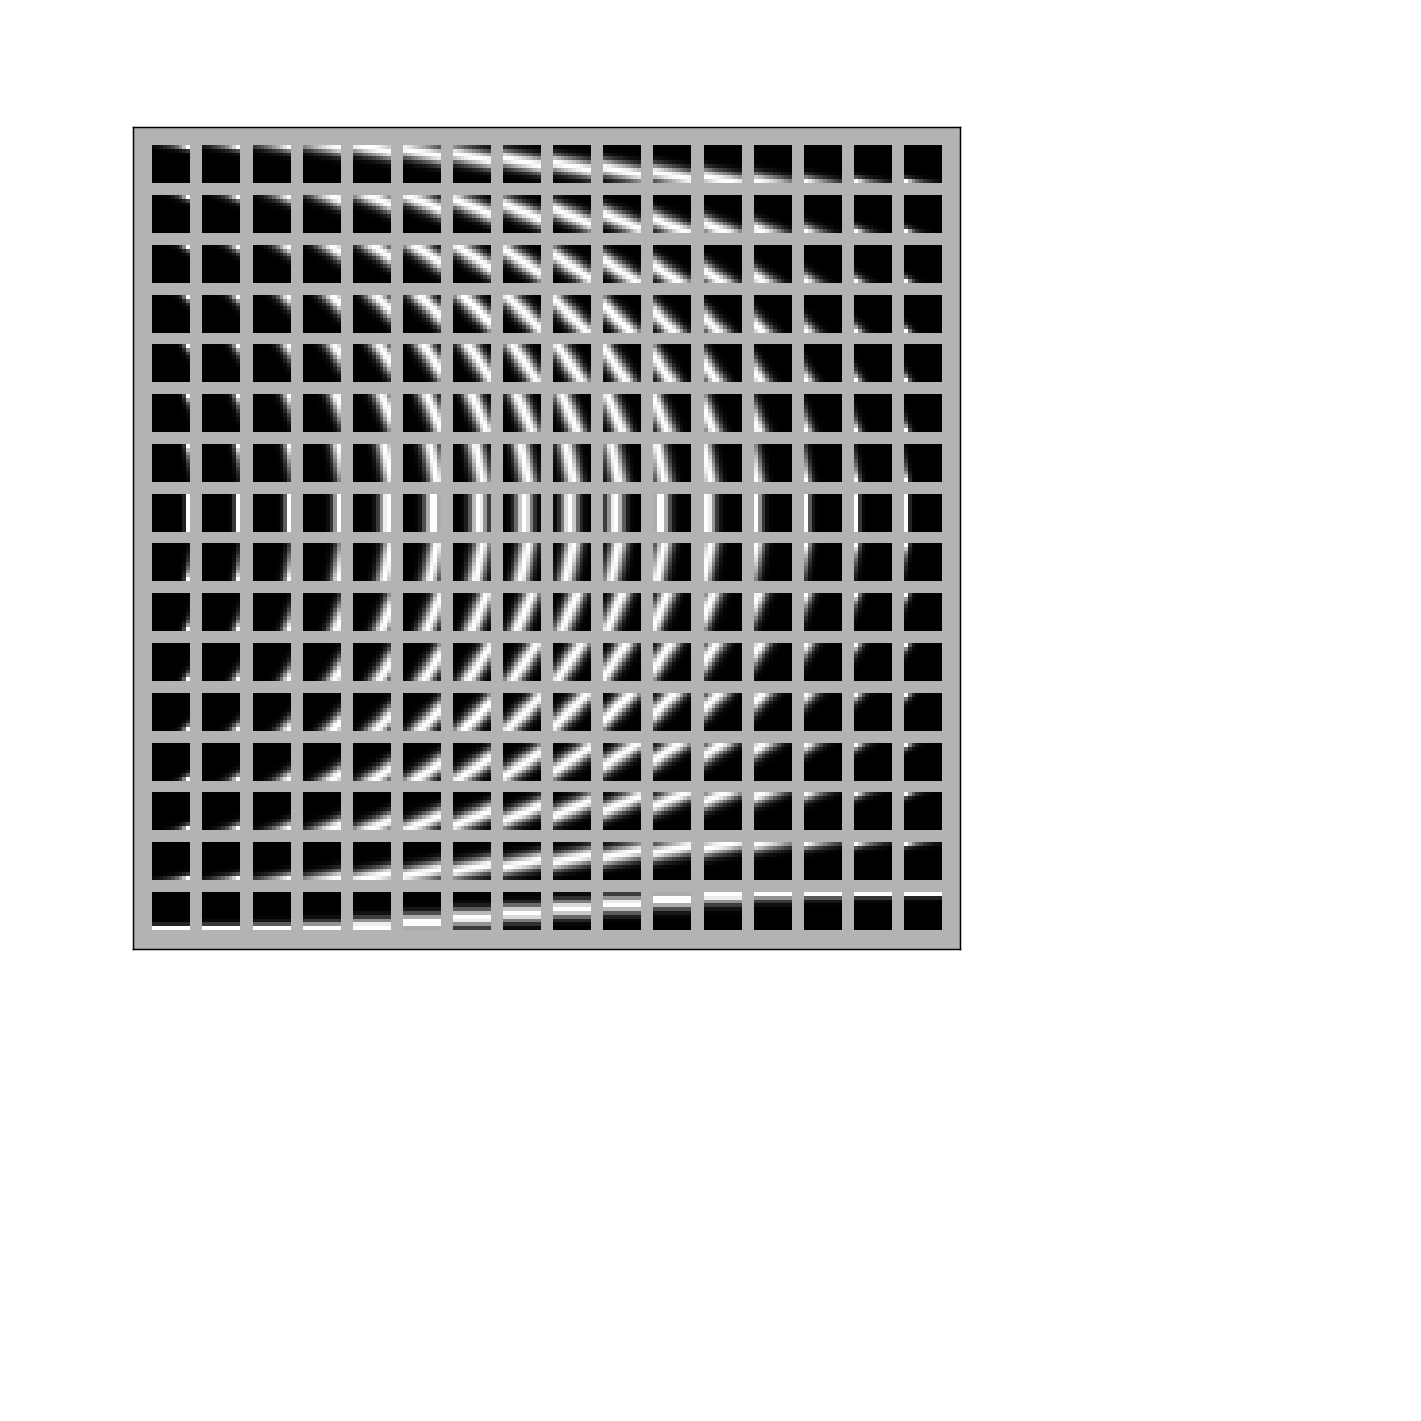

In [4]:
def getLinePatches(dim, NAngles, NOffsets, sigma):
    """
    Sample a set of line segments, as witnessed by square patches
    Parameters
    ----------
    dim: int
        Patches will be dim x dim
    NAngles: int
        Number of angles to sweep between 0 and pi
    NOffsets: int
        Number of offsets to sweep from the origin to the edge of the patch
    sigma: float
        The blur parameter.  Higher sigma is more blur
    """
    N = NAngles*NOffsets
    P = np.zeros((N, dim*dim))
    thetas = np.linspace(0, np.pi, NAngles+1)[0:NAngles]
    #ps = np.linspace(-0.5*np.sqrt(2), 0.5*np.sqrt(2), NOffsets)
    ps = np.linspace(-1, 1, NOffsets)
    idx = 0
    [Y, X] = np.meshgrid(np.linspace(-0.5, 0.5, dim), np.linspace(-0.5, 0.5, dim))
    for i in range(NAngles):
        c = np.cos(thetas[i])
        s = np.sin(thetas[i])
        for j in range(NOffsets):
            patch = X*c + Y*s + ps[j]
            patch = np.exp(-patch**2/sigma**2)
            P[idx, :] = patch.flatten()
            idx += 1
    return P

P = getLinePatches(dim=10, NAngles = 16, NOffsets = 16, sigma=0.25)
plt.figure(figsize=(8, 8))
plotPatches(P, zoom=2)
ax = plt.gca()
ax.set_facecolor((0.7, 0.7, 0.7))
plt.show()

Now let's compute persistence diagrams for this collection of patches.  This time, we will compute with both $\mathbb{Z}/2$ coefficients and $\mathbb{Z}/3$ coefficients up to H2.

<IPython.core.display.Javascript object>


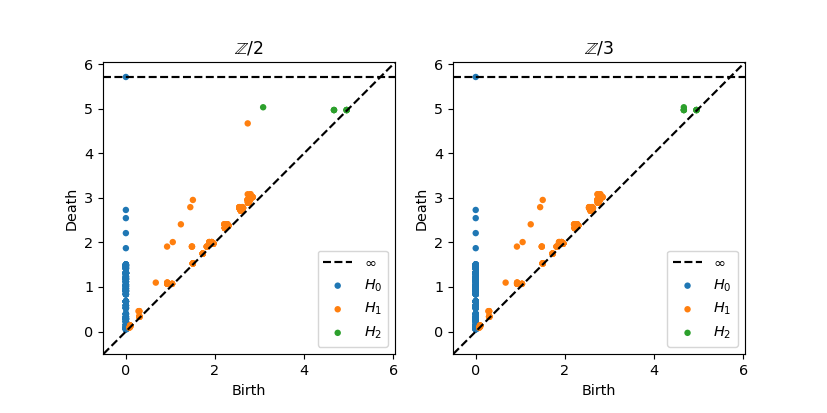

In [5]:
dgmsz2 = ripser(P, coeff=2, maxdim=2)['dgms']
dgmsz3 = ripser(P, coeff=3, maxdim=2)['dgms']
plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_dgms(dgmsz2)
plt.title("$\mathbb{Z}/2$")
plt.subplot(122)
plot_dgms(dgmsz3)
plt.title("$\mathbb{Z}/3$")
plt.show()

Notice how there is one higher persistence dot both for H1 and H2, which both go away when switching to $\mathbb{Z} / 3\mathbb{Z}$.  This is the signature of the projective plane!  To verify this, we will now look at these patches using "projective coordinates" (finding a map to $RP^2$).


Max persistence index 0, peristence 2.4123587608337402


<IPython.core.display.Javascript object>


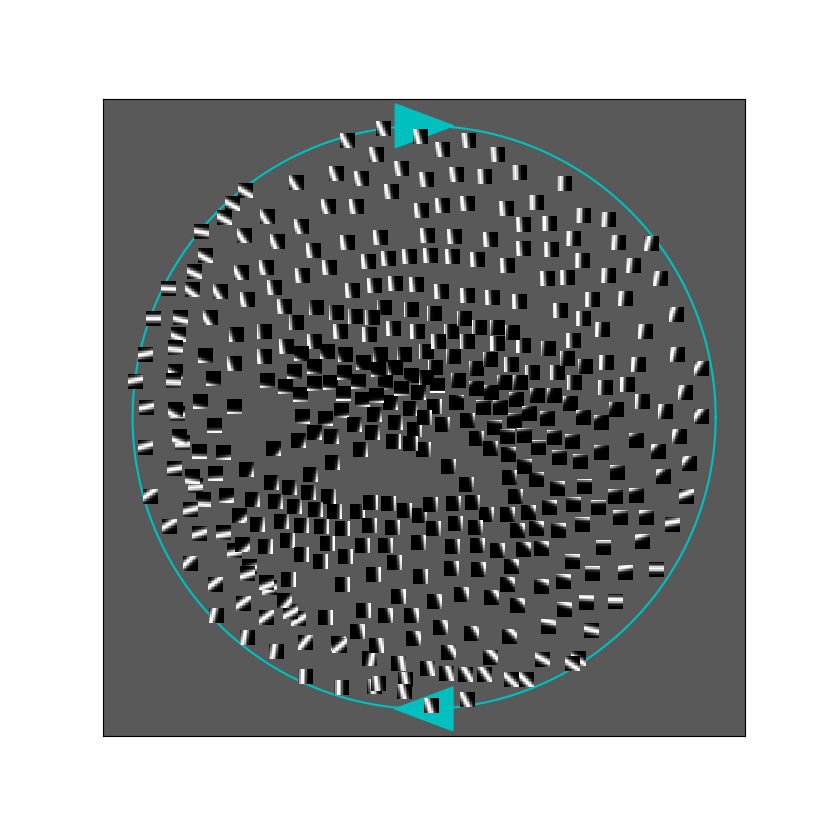

In [6]:
def plotProjBoundary():
    t = np.linspace(0, 2*np.pi, 200)
    plt.plot(np.cos(t), np.sin(t), 'c')
    plt.axis('equal')
    ax = plt.gca()
    ax.arrow(-0.1, 1, 0.001, 0, head_width = 0.15, head_length = 0.2, fc = 'c', ec = 'c', width = 0)
    ax.arrow(0.1, -1, -0.001, 0, head_width = 0.15, head_length = 0.2, fc = 'c', ec = 'c', width = 0)
    ax.set_facecolor((0.35, 0.35, 0.35))

P = getLinePatches(dim=10, NAngles = 200, NOffsets = 200, sigma=0.25)
proj = ProjectiveCoords(P, n_landmarks=100)
h1 = proj.dgms_[1]
# Find the index with greatest persistence in H1 and use
# the cocycle corresponding to that
idx = np.argmax(h1[:, 1]-h1[:, 0])
print("Max persistence index {}, peristence {}".format(idx, h1[idx, 1]-h1[idx, 0]))
res = proj.get_coordinates(proj_dim=2, perc=0.9, cocycle_idx=[idx])
X = res['X']
idx = getGreedyPerm(X, 400)['perm']
SFinal = get_stereo_proj_codim1(X[idx, :])
P = P[idx, :]

plt.figure(figsize=(8, 8))
imscatter(SFinal, P, 10)
plotProjBoundary()
plt.show()